In [1]:
# Import my code
from tensorfactorization.utils import (defactorizing_CP, create_initial_data, random_cp_with_noise)
from tensorfactorization.multiplicative import (tensor_factorization_cp_multiplicative, tensor_factorization_cp_multiplicative_poisson)
from tensorfactorization.poisson import (
    BacktrackingWarning, tensor_factorization_cp_poisson, tensor_factorization_cp_poisson_fixed_step_size, 
    tensor_factorization_cp_poisson_exp, tensor_factorization_cp_poisson_SMART, tensor_factorization_cp_SMART_fixed_step_size
)

from toolkit.constants import (
    picture_folder, data_folder, 
    error_label, iteration_label, tensor_dimension_label, time_label, 
    xscale_convergence_data, xscale_convergence, yscale_convergence
)
from toolkit.classes import (
    IterationResult,
    Factorizer
)
from toolkit.evaluate import (
    evaluate_on_random, evaluate_on_data, evaluate_on_images, 
    plot_trajectories,
    plot_calculation_times_and_niter,
    to_image
)

from data.data_imports import load_indian_pines

#%matplotlib widget
import tensorly as tl
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pickle # use pickle to save results to disk
import warnings

from copy import deepcopy

## Evaluate All Algorithms

In [2]:
# CREATE FACTORIZER OBJECTS FOR ALL ALGORITHMS
max_iter_default = 2000

# The standart multiplicative algorithm
def multiplicative_factorization(tensor, F, initial_A_ns, max_iter):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_multiplicative = Factorizer("Multiplicative", multiplicative_factorization, color='red')

# The Poisson variant of the multiplicative algorithm
def multiplicative_poisson_factorization(tensor, F, initial_A_ns, max_iter):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative_poisson(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_multiplicative_poisson = Factorizer("Multiplicative Poisson", multiplicative_poisson_factorization, color='orange')


# The new geometric algorithm with step size calculation and without any form of normalization
def geometric_variable_step_size(tensor, F, initial_A_ns, max_iter):
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric = Factorizer("Geometric step size calculation without rescaling", geometric_variable_step_size, color='blue')

# The new geometric algorithm with step size calculation and but normalization of the tensor and the initial data
def geometric_variable_normalized(tensor, F, initial_A_ns, max_iter):
    # copy tensor and initial data and rescale
    norm_of_tensor = tl.norm(tensor)
    tensor_copy = tensor / norm_of_tensor # normalize tensor
    norm_of_approximation = tl.norm(defactorizing_CP(initial_A_ns, tensor.shape))
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / norm_of_approximation) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_norm = Factorizer("Geometric step size calculation with normalization", geometric_variable_normalized, color='blue', linestyle='dotted')

# The new geometric algorithm with step size calculation and but max=1 of the tensor and the initial data
def geometric_variable_normalize_max(tensor, F, initial_A_ns, max_iter):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.max(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.max(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_max = Factorizer("Geometric step size calculation with max = 1", geometric_variable_normalize_max, color='blue', linestyle='dashed')

# The new geometric algorithm with step size calculation and but mean=1 of the tensor and the initial data
def geometric_variable_normalize_mean(tensor, F, initial_A_ns, max_iter):
    # copy tensor and initial data and rescale
    tensor_mean = tl.mean(tensor)
    tensor_copy = tensor / tensor_mean # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    # rescale the A_ns to the original scaling so that we have comparitability
    scaling = tensor_mean ** (1.0/ tensor.ndim)
    for n in range(len(A_ns)):
        A_ns[n] = A_ns[n] * scaling
    #print(f"Norm of tensor: {tl.norm(tensor)}, norm of approx: {tl.norm(defactorizing_CP(A_ns, tensor.shape))}, norm of difference: {tl.norm(tensor - defactorizing_CP(A_ns, tensor.shape))}")
    return IterationResult(tl.tensor(RE), end-start, A_ns)
#factorizer_geometric_mean = Factorizer("Geometric step size calculation with mean = 1", geometric_variable_normalize_mean, color='blue', linestyle='solid')
factorizer_geometric_mean = Factorizer("Geometric Algorithm", geometric_variable_normalize_mean, color='blue', linestyle='solid')


# default geometric algorithm with fixed step size. Use normalize the mean of the tensor to get some form of normalization
def geometric_fixed_step_size(tensor, F, initial_A_ns, max_iter):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.mean(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson_fixed_step_size(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_fixed = Factorizer("Geometric fixed step size", geometric_fixed_step_size, color='green')


# The new geometric algorithm with step size calculation and but mean=1 of the tensor and the initial data
def geometric_exp(tensor, F, initial_A_ns, max_iter):
    # copy tensor and initial data and rescale
    tensor_mean = tl.mean(tensor)
    tensor_copy = tensor / tensor_mean # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson_exp(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    # rescale the A_ns to the original scaling so that we have comparitability
    scaling = tensor_mean ** (1.0/ tensor.ndim)
    for n in range(len(A_ns)):
        A_ns[n] = A_ns[n] * scaling
    #print(f"Norm of tensor: {tl.norm(tensor)}, norm of approx: {tl.norm(defactorizing_CP(A_ns, tensor.shape))}, norm of difference: {tl.norm(tensor - defactorizing_CP(A_ns, tensor.shape))}")
    return IterationResult(tl.tensor(RE), end-start, A_ns)
#factorizer_geometric_mean = Factorizer("Geometric step size calculation with mean = 1", geometric_variable_normalize_mean, color='blue', linestyle='solid')
factorizer_geometric_exp = Factorizer("Geometric Algorithm EXP", geometric_exp, color='purple', linestyle='solid')

# The new geometric algorithm with step size calculation and but mean=1 of the tensor and the initial data
def geometric_smart(tensor, F, initial_A_ns, max_iter):
    # copy tensor and initial data and rescale
    tensor_mean = tl.mean(tensor)
    tensor_copy = tensor / tensor_mean # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson_SMART(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    # rescale the A_ns to the original scaling so that we have comparitability
    scaling = tensor_mean ** (1.0/ tensor.ndim)
    for n in range(len(A_ns)):
        A_ns[n] = A_ns[n] * scaling
    #print(f"Norm of tensor: {tl.norm(tensor)}, norm of approx: {tl.norm(defactorizing_CP(A_ns, tensor.shape))}, norm of difference: {tl.norm(tensor - defactorizing_CP(A_ns, tensor.shape))}")
    return IterationResult(tl.tensor(RE), end-start, A_ns)
#factorizer_geometric_mean = Factorizer("Geometric step size calculation with mean = 1", geometric_variable_normalize_mean, color='blue', linestyle='solid')
factorizer_geometric_smart = Factorizer("Geometric Algorithm SMART", geometric_smart, color='green', linestyle='solid')

# The new geometric algorithm with step size calculation and but mean=1 of the tensor and the initial data
def geometric_smart_fixed(tensor, F, initial_A_ns, max_iter):
    # copy tensor and initial data and rescale
    tensor_mean = tl.mean(tensor)
    tensor_copy = tensor / tensor_mean # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_SMART_fixed_step_size(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    # rescale the A_ns to the original scaling so that we have comparitability
    scaling = tensor_mean ** (1.0/ tensor.ndim)
    for n in range(len(A_ns)):
        A_ns[n] = A_ns[n] * scaling
    #print(f"Norm of tensor: {tl.norm(tensor)}, norm of approx: {tl.norm(defactorizing_CP(A_ns, tensor.shape))}, norm of difference: {tl.norm(tensor - defactorizing_CP(A_ns, tensor.shape))}")
    return IterationResult(tl.tensor(RE), end-start, A_ns)
#factorizer_geometric_mean = Factorizer("Geometric step size calculation with mean = 1", geometric_variable_normalize_mean, color='blue', linestyle='solid')
factorizer_geometric_smart_fixed = Factorizer("Geometric Algorithm SMART fixed", geometric_smart_fixed, color='black', linestyle='solid')



# run the factorization on gpu
run_on_gpu = True
if run_on_gpu:
    tl.set_backend('pytorch')
    context = {'dtype': tl.float64,
               'device': 'cuda'}
else:
    tl.set_backend('numpy')
    context = {'dtype': tl.float64}
    
factorizers = [
    factorizer_multiplicative,
    factorizer_multiplicative_poisson,
    #factorizer_geometric,
    #factorizer_geometric_norm,
    #factorizer_geometric_max,
    factorizer_geometric_mean,
    #factorizer_geometric_fixed,
    #factorizer_geometric_exp,
    factorizer_geometric_smart,
    factorizer_geometric_smart_fixed
]

C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(



Testing on indian_pines data:
Tensor is of shape: torch.Size([145, 145, 200])
Multiplicative converged in 6.387 seconds and 559 iterations
Multiplicative Poisson converged in 19.794 seconds and 1651 iterations
Geometric Algorithm converged in 28.811 seconds and 448 iterations
Geometric Algorithm EXP converged in 18.798 seconds and 293 iterations
Geometric Algorithm SMART converged in 9.647 seconds and 132 iterations
Geometric Algorithm SMART fixed converged in 31.350 seconds and 2001 iterations
Multiplicative converged in 13.018 seconds and 1070 iterations
Multiplicative Poisson converged in 7.897 seconds and 620 iterations
Geometric Algorithm converged in 15.329 seconds and 225 iterations
Geometric Algorithm EXP converged in 12.062 seconds and 176 iterations
Geometric Algorithm SMART converged in 7.918 seconds and 103 iterations
Geometric Algorithm SMART fixed converged in 31.274 seconds and 2001 iterations
calculation times
Algorithm Multiplicative took 9.70272159576416 seconds on a

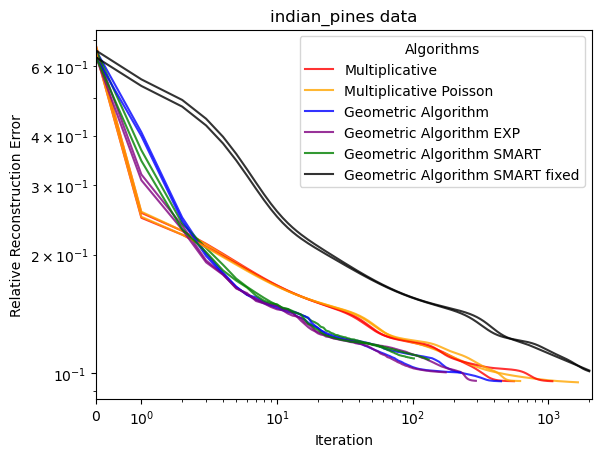

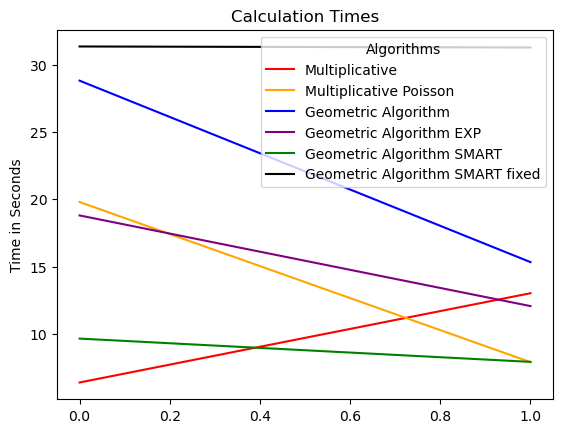

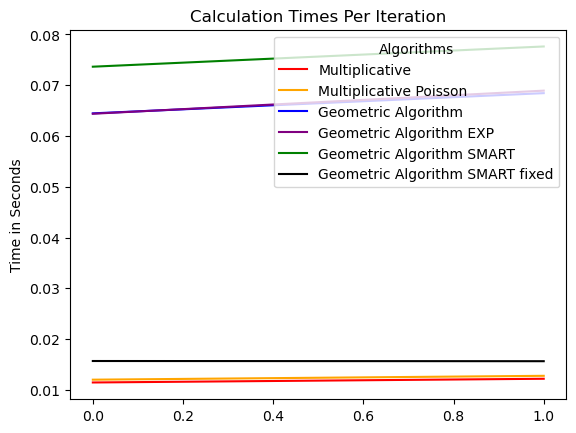

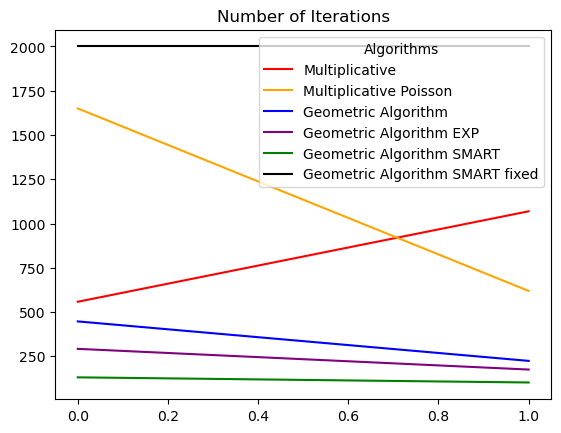

In [3]:
#evaluate_on_random(factorizers, context=context)
evaluate_on_data(factorizers, context=context, nrepetitions=2)
#evaluate_on_images(factorizers, context=context)
plot_calculation_times_and_niter(factorizers)

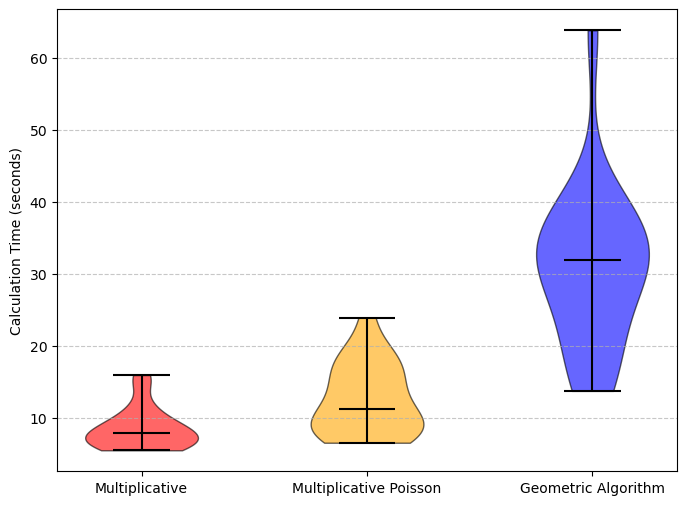

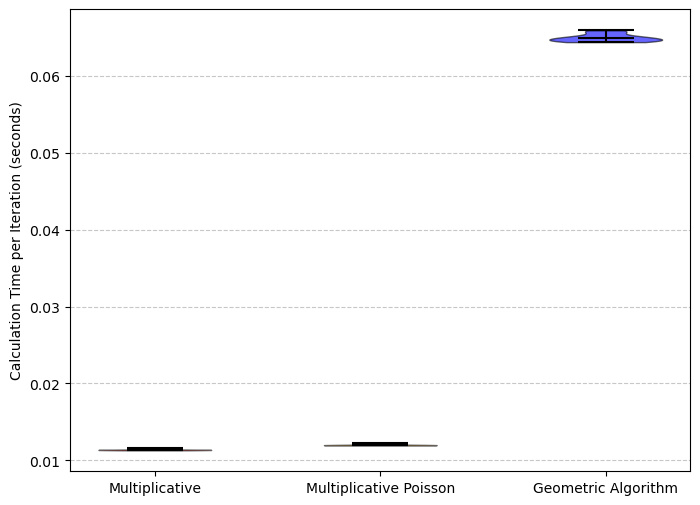

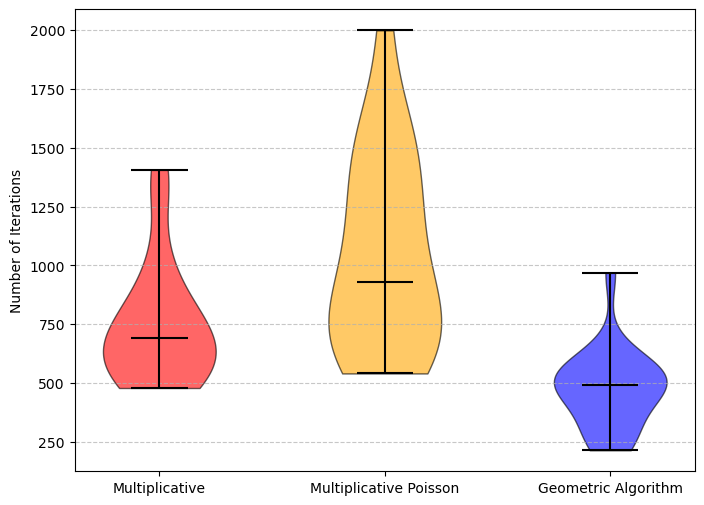

In [21]:
def violinplot(data, labels, colors, ylabel, filename):
    # Create the Violin Plot
    plt.figure(figsize=(8, 6))
    parts = plt.violinplot(data, showmeans=False, showmedians=True)
    
    # Iterate through the violin plot bodies and set the colors
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.6)
    
    # Set the color for the medians and other parts
    for partname in ('cbars', 'cmaxes', 'cmins', 'cmedians'):
        vp = parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1.5)
    
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(np.arange(1, len(labels) + 1), labels=labels)
    plt.savefig(f"{picture_folder}{filename}.png", bbox_inches='tight')
    #plt.show()

def violinplot_algorithms(factorizers):
    calculation_times = []
    calculation_times_per_iteration = []
    number_of_iterations = []
    labels = []
    colors = []
    for factorizer in factorizers:
        calculation_times.append(factorizer.get_calculation_times())
        calculation_times_per_iteration.append(factorizer.get_calculation_times_per_iteration())
        number_of_iterations.append(factorizer.get_number_of_iterations())
        labels.append(factorizer.label)
        colors.append(factorizer.color)
    violinplot(calculation_times, labels, colors, 'Calculation Time (seconds)', "calculation_times")
    violinplot(calculation_times_per_iteration, labels, colors, 'Calculation Time per Iteration (seconds)', "calculation_times_per_iteration")
    violinplot(number_of_iterations, labels, colors, 'Number of Iterations', "number_of_iterations")
    
    

violinplot_algorithms(factorizers)

Text(0.5, 1.0, 'Number of Iterations')

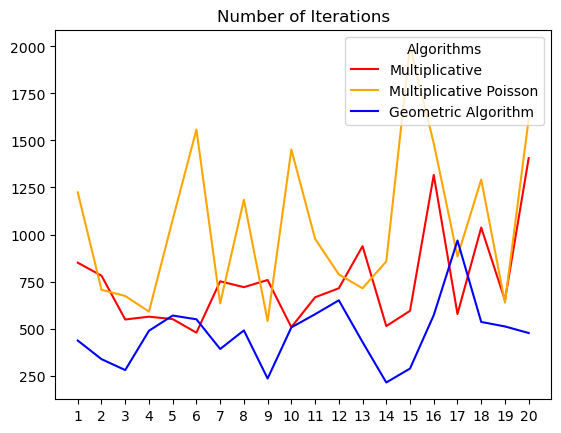

In [12]:
plt.figure()
for factorizer in factorizers:
    x = np.arange(1, len(factorizer.get_number_of_iterations())+1)
    plt.plot(x, factorizer.get_number_of_iterations(), color=factorizer.color, label=factorizer.label, linestyle=factorizer.linestyle)
    #print_mean_and_variance(factorizer.get_number_of_iterations(), factorizer.label)
plt.xticks(x)
plt.legend(title='Algorithms', loc='upper right')
plt.title("Number of Iterations")



torch.Size([145, 145, 200])
tensor(955.)
tensor(9604.)


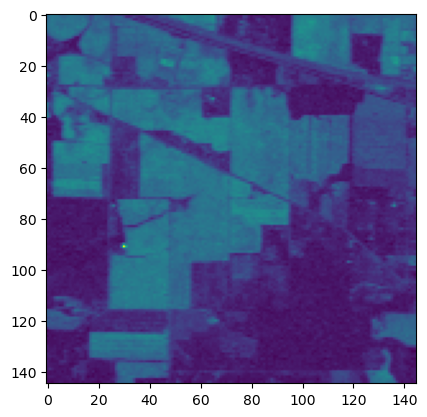

In [25]:
indian_pines = load_indian_pines()
tensor = tl.tensor(indian_pines.tensor)
print(tensor.shape)
print(tl.min(tensor))
print(tl.max(tensor))
plt.imshow(to_image(tensor[:,:,190]))

# Plot Trajectories of Parts of Tensors

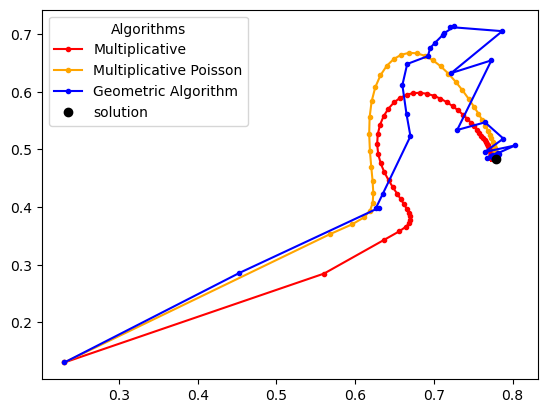

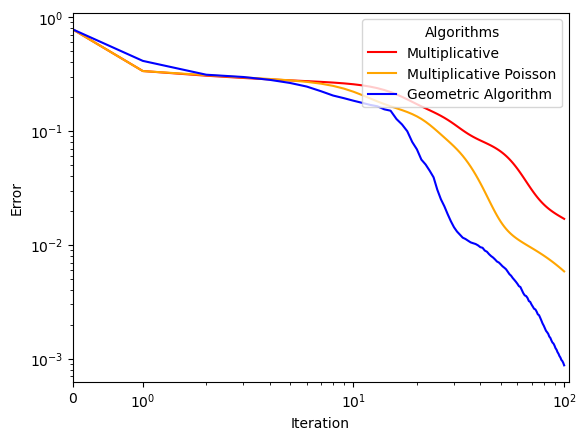

In [17]:
#indian_pines = load_indian_pines()
#tensor = tl.tensor(indian_pines.tensor, **context)
F = 3

tensor = random_cp_with_noise((10,10,10), F, noise_scaling=0.0, context=context)

index0 = (1, 1, 1)
index1 = (1, 1, 2)
indices = [index0, index1]

plot_trajectories(factorizers, tensor, F, indices, max_iter=100)

# Show the Factor Parts of Decomposition

In [12]:
from skimage import data
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}

tensor = tl.tensor(data.colorwheel(), **context)
tensor[tensor > 1e-6] = 1
print(tl.sort(tensor, None))
print(tl.prod(tl.tensor(tensor.size())))
#tensor = random_cp_with_noise((10,10,10), 2)
J = 6
initial_Ans = create_initial_data(tensor, J)
result = geometric_variable_normalize_mean(tensor, J, initial_Ans)


fig, axes = plt.subplots(nrows=1, ncols=J+2, figsize=(20,20))
axes[0].set_title("retina")
axes[0].set_axis_off()
axes[0].imshow(to_image(tensor))

axes[1].set_title("Reconstruction")
axes[1].set_axis_off()
axes[1].imshow(to_image(defactorizing_CP(result.A_ns, tensor.shape)))

for index in range(2,J+2):
    columns = []
    for A_n in result.A_ns:
        columns.append(A_n[:,index-2])
    rank1_tensor = tl.tenalg.outer(columns)
    axes[index].set_title(f"Component {index-1}")
    axes[index].set_xticks([])
    axes[index].set_yticks([])
    axes[index].imshow(to_image(rank1_tensor))

#fig.show()

tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')
tensor(411810.)


TypeError: geometric_variable_normalize_mean() missing 1 required positional argument: 'max_iter'